In [343]:
import numpy as np
import scipy 
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [287]:
def payoff(S,K):
    return np.maximum(S-K,0)

def Milstein( func, S0 = 1125, K = 1125, r = 0,
             eta = 0.388, lam = 1.33, rho = -0.717,vmean = 0.0354,
             v0 = 0.18**2,N = 105 ,n = 1000,T = 5/12):
    
    # N: number of intervals
    # n: number of paths
    # T: maturity
    dt = float(T/N) #interval of each path
    
    W = norm.rvs(size = (n,N))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (n,N))*np.sqrt(dt)
 
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    V = np.zeros((n,N+1)) # V is our variance 
    V[:,0] = v0
    S = np.zeros((n,N+1)) # S is our stock price
    S[:,0] = S0
    
    
    for i in range(1,N+1):
        V[:,i] = V[:,i-1] - lam*(V[:,i-1] -vmean)*dt + eta*np.sqrt(V[:,i-1])*B[:,i-1]+0.25*eta**2*(B[:,i-1]**2 - dt)
        V[:,i] = np.abs(V[:,i])
        
    dlogS = (r - 0.5*V[:,:-1])*dt + np.sqrt(V[:,:-1])*W
    dlogS_sum = np.cumsum(dlogS,axis = 1)
    S[:,1:] = S0*np.exp(dlogS_sum)
    
    price = np.mean(func(S[:,N],K))*np.exp(-r*T)
   
    return price
num = 10
Price_Vec = np.array([Milstein(payoff) for i in range(num)])
print('price: ',np.mean(Price_Vec),'\n')
print('std: ',np.std(Price_Vec))

price:  49.24590747032092 

std:  1.4676017358172992


In [337]:

def ExoticVar(random_seed = 0, S0 = 1125, K = 0.191**2, r = 0,
              eta = 0.388, lam = 1.33, rho = -0.717,vmean = 0.0354,
              v0 = 0.18**2,N = 100 ,n = 100,Np = 1000,T = 5/12,choice = 0,notional = 1000):
    
    # N: number of intervals
    # n: number of paths
    # T: maturity
    np.random.seed(random_seed)
    dt = float(T/N) #interval of each path
    
    W = norm.rvs(size = (n,N,Np))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (n,N,Np))*np.sqrt(dt)
 
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    V = np.zeros((n,N+1,Np)) # V is our variance 
    V[:,0,:] = v0
    S = np.zeros((n,N+1,Np)) # S is our stock price
    S[:,0,:] = S0
    
    
    for i in range(1,N+1):
        V[:,i,:] = V[:,i-1,:] - lam*(V[:,i-1,:] -vmean)*dt + eta*np.sqrt(V[:,i-1,:])*B[:,i-1,:]+0.25*eta**2*(B[:,i-1,:]**2 - dt)
        V[:,i,:] = np.abs(V[:,i,:])
        
    dlogS = (r - 0.5*V[:,:-1,:])*dt + np.sqrt(V[:,:-1,:])*W
    dlogS_sum = np.cumsum(dlogS,axis = 1)
    S[:,1:,:] = S0*np.exp(dlogS_sum)
    
    Smax = np.max(S, axis = 1)
    
    if choice == 0:
        #call on variance at time T
        # payoff = (sigmaT^2 - K)+ * I(ST <= 0.9Smax)
        # V = sigma^2 
        V_mean = np.mean(V, axis = 1)
        payoff = notional*np.exp(-r*T)*np.maximum(V_mean - K,0)*(S[:,N,:] <= 0.9*Smax)/(2*np.sqrt(K))
        
    elif choice == 1:
        #filtering time
        #call on average variance in [0,T]
        V_filter = V*(S <= 0.9*S0)
        V_mean = np.mean(V_filter,axis = 1)
        payoff = notional*np.exp(-r*T)*np.maximum(V_mean - K,0)*(S[:,N,:] <= 0.9*Smax)/(2*np.sqrt(K))
        
    elif choice == 2:
        payoff = np.exp(-r*T)*np.maximum(S[:,N,:]-K,0)
        print()
        
       
     
    
    print(payoff.shape)
    price_seq = np.mean(payoff,axis = 0)
    
    standard_deviation = np.std(price_seq)
    price = np.mean(price_seq)
    print('price: ',price)
    print('std: ',standard_deviation)
    return price

def GreeksCalculate(ExoticVar,S0 = 100, K = 0.191**2, r = 0.1,
             eta = 0.388, lam = 1.33, rho = -0.717,vmean = 0.0354,
             v0 = 0.18**2,N = 100 ,n = 100,Np = 1000,T = 5/12,
             choice = 1,flag = np.array([0,1,0])):
    
    #ExoticVar(S0,K,r,eta,lam,rho,vmean,v0,N,n,T,choice)
    
    #flag = np.array([1,1,0])
    result = np.zeros((3,2))
    
    num = 2
    
    if flag[0] == 1:
    #calculate delta
        
        h = 0.01
        if 'price_s_plus' not in vars():
            price_s_plus = np.array([ExoticVar(i,S0*(1+h),K,r,eta,lam,rho,vmean,v0,N,n,Np,T,choice) for i in range(num)])
        if 'price_s_minus' not in vars():
            price_s_minus = np.array([ExoticVar(i,S0*(1-h),K,r,eta,lam,rho,vmean,v0,N,n,Np,T,choice) for i in range(num)])
        
        delta_seq = (price_s_plus - price_s_minus)/(2*h*S0)
        print(delta_seq)
        delta = np.mean(delta_seq)
        delta_std = np.std(delta_seq)
        print('\n')
        print('delta: ',delta,'\n')
        print('delta_std: ',delta_std,'\n')
        result[0] = np.array([delta,delta_std])
    if flag[1] == 1:
        
        h = 0.001
        if 'price_v_plus' not in vars():
            price_v_plus = np.array([ExoticVar(i,S0,K,r,eta,lam,rho,vmean,v0*(1+h)**2,N,n,Np,T,choice) for i in range(num)])
        if 'price_v_minus'not in vars():
            price_v_minus = np.array([ExoticVar(i,S0,K,r,eta,lam,rho,vmean,v0*(1-h)**2,N,n,Np,T,choice) for i in range(num)])
        vega_seq = (price_v_plus - price_v_minus)/(2*h*v0**0.5)
        
        vega = np.mean(vega_seq)
        vega_std = np.std(vega_seq)
        
        print('\n')
        #print('vega_seq',vega_seq)
        print('vega: ',vega)
        print('vega_std: ',vega_std)
        #print('std/mean: ',vega_std/vega)
        result[1] = np.array([vega,vega_std])
    if flag[2] == 1:
        h = 0.001
        if 'price_s_plus' not in vars():
            price_s_plus = np.array([ExoticVar(i,S0*(1+h),K,r,eta,lam,rho,vmean,v0,N,n,Np,T,choice) for i in range(num)])
        if 'price_s_minus' not in vars():
            price_s_minus = np.array([ExoticVar(i,S0*(1-h),K,r,eta,lam,rho,vmean,v0,N,n,Np,T,choice) for i in range(num)])
        if 'price_s' not in vars():
            price_s = np.array([ExoticVar(i,S0,K,r,eta,lam,rho,vmean,v0,N,n,Np,T,choice) for i in range(num)])
        gamma_seq = (price_s_plus + price_s_minus - 2*price_s)/2*(h*S0)**2
        gamma = np.mean(gamma_seq)  
        gamma_std = np.std(gamma)
        print('\n')
        print('gamma: ',gamma)
        print('gamma_std: ',gamma_std)
        result[2] = np.array([gamma,gamma_std])
        
    
    return result

ExoticVar()
X = GreeksCalculate(ExoticVar,flag = np.array([1,1,0]))
print('maya')
print(X.shape)



(100, 1000)
price:  12.674375229367334
std:  3.579078433112467
(100, 1000)
price:  3.5192178353284014
std:  1.970055405234055
(100, 1000)
price:  3.5589820938311476
std:  1.949199315248269
(100, 1000)
price:  3.5192178353284014
std:  1.970055405234055
(100, 1000)
price:  3.5589820938311476
std:  1.949199315248269
[0. 0.]


delta:  0.0 

delta_std:  0.0 

(100, 1000)
price:  3.529996221234471
std:  1.9735038242232148
(100, 1000)
price:  3.570987102434312
std:  1.954145487795554
(100, 1000)
price:  3.5076081077081733
std:  1.9657121469453822
(100, 1000)
price:  3.547211365772853
std:  1.9463370519105663


vega:  64.11645859410639
vega_std:  1.9272543543909713
maya
(3, 2)


array([[ 0.        ,  0.        ],
       [64.11645859,  1.92725435],
       [ 0.        ,  0.        ]])

In [365]:
def Hedge(random_seed = 0, S0 = 1125, K = 0.191**2, 
          r = 0.0411,eta = 0.388, lam = 1.33, rho = -0.717,vmean = 0.0354,
          v0 = 0.11**2,N = 252 ,n = 100,Np = 100,T = 1,choice = 0,
          notional = 1000,N_hedge = 60
         ):
    print(N_hedge)
    
    np.random.seed(1000)
    dt = float(T/N) #interval of each path
    W = norm.rvs(size = (n,N,Np))*np.sqrt(dt)
    Wtilde = norm.rvs(size = (n,N,Np))*np.sqrt(dt)
 
    B = rho*W + np.sqrt(1-rho**2)*Wtilde
    
    V = np.zeros((n,N+1,Np)) # V is our variance 
    V[:,0,:] = v0
    S = np.zeros((n,N+1,Np)) # S is our stock price
    S[:,0,:] = S0
    
    #
    interval = int(N/N_hedge)
    
    
    #stock
    asset_S = np.zeros((3,N_hedge+1))
    asset_S[1,:] = 1 #delta = 1
    asset_S[2,:] = 0 #vega = 0
    
    #Call choice = 2
    #calculate delta,vega
    #at the money S0,S0
    asset_C = np.zeros((3,N_hedge+1))
    greekC = GreeksCalculate(ExoticVar,S0,S0, r,eta,lam ,rho,vmean,v0,N ,n,Np,T,2,np.array([1,1,0]))
    (asset_C[1,0],asset_C[2,0]) = (greekC[0,0],greekC[1,0])
    price_C = np.zeros(N_hedge+1)
    price_C[0] = ExoticVar(1, S0,S0,r,eta,lam, rho ,vmean , v0,N,n ,Np ,T ,2,notional)
    #OTC choice = 0
    #calculate delta, vega
    #OTC strike K
    asset_O = np.zeros((3,N_hedge+1))
    greekO = GreeksCalculate(ExoticVar,S0,K, r,eta,lam, rho,vmean,v0,N ,n,Np,T,0,np.array([1,1,0]))
    (asset_O[1,0],asset_O[2,0]) = (greekO[0,0],greekO[1,0])
    price_O = np.zeros(N_hedge+1)
    price_O[0] = ExoticVar(1,S0,K,r,eta,lam,rho,vmean,v0,N,n,Np,T, 0,notional)
    # each column: position delta, vega
    
    (asset_S[0,0],asset_C[0,0]) = np.linalg.inv(np.array([[1,asset_C[1,0]],[0,asset_C[2,0]]])\
                                               ).dot(np.array([asset_O[1,0],asset_O[2,0]]))
    
    # portfolio 
    C_pnl = np.zeros(N_hedge+1)
    O_pnl = np.zeros(N_hedge+1)
    C_pnl_cost = np.zeros(N_hedge+1)
    #O_pnl_cost = np.zeros(N_hedge+1)
    
    
    #strats
    (a,b) = (0,0)
    cost = 0.125
    for i in range(1,N+1):
        V[:,i,:] = V[:,i-1,:] - lam*(V[:,i-1,:] -vmean)*dt + eta*np.sqrt(V[:,i-1,:])*B[:,i-1,:]+0.25*eta**2*(B[:,i-1,:]**2 - dt)
        V[:,i,:] = np.abs(V[:,i,:])
        S[:,i,:] = S[:,i-1,:]*np.exp((r - 0.5*V[:,i-1,:])*dt + np.sqrt(V[:,i-1,:])*W[:,i-1,:])
        
        if  i%interval == 0:
            k = int(i/interval)
            
            # C price, greeks
            greekC = GreeksCalculate(ExoticVar,S[a,i,b],S[a,i,b], r,eta,lam, rho,vmean,V[a,i,b],N ,n,Np,T,2,np.array([1,1,0]))
            (asset_C[1,k],asset_C[2,k]) = (greekC[0,0],greekC[1,0])
            price_C[k] = ExoticVar(k+1, S[a,i,b],S[a,i,b],r,eta,lam, rho ,vmean,V[a,i,b],N,n ,Np ,T ,2,notional)
            
            
            #O price, greeks
            greekO = GreeksCalculate(ExoticVar,S[a,i,b],K, r,eta,lam, rho,vmean,V[a,i,b],N ,n,Np,T,0,np.array([1,1,0]))
            (asset_O[1,k],asset_O[2,k]) = (greekO[0,0],greekO[1,0])
            (asset_S[0,k],asset_C[0,k]) = np.linalg.inv(np.array([[1,asset_C[1,k]],[0,asset_C[2,k]]])\
                                               ).dot(np.array([asset_O[1,k],asset_O[2,k]]))
            price_O[k] = ExoticVar(k+1,S[a,i,b],K,r,eta,lam,rho,vmean,V[a,i,b],N,n,Np,T,0,notional)
            
            
            #pnl
            C_pnl[k] = asset_S[0,k-1]*(S[a,i,b] - S[a,(i-interval),b]) + asset_C[0,k-1]*(price_C[k] - price_C[k-1])
            O_pnl[k] = 1 * (price_O[k] - price_O[k-1])
            C_pnl_cost[k] = C_pnl[k] - (abs(asset_S[0,k] - asset_S[0,k-1])+ abs(asset_C[0,k] - asset_C[0,k-1]))*cost
            
    X = C_pnl - O_pnl
    plt.plot(C_pnl,label = 'hedging')
    plt.plot(O_pnl,label = 'OTC product')
    plt.plot(X,label = 'total pnl')
    plt.legend()       
 
    return C_pnl,O_pnl,C_pnl_cost
    
    
    
C_pnl,O_pnl,C_pnl_cost = Hedge()
    
    

60

(100, 100)
price:  97.29699151669638
std:  9.42191291450257

(100, 100)
price:  98.85690139184061
std:  10.595856394798899

(100, 100)
price:  80.66783374201096
std:  8.669625719806545

(100, 100)
price:  82.09247366509184
std:  9.730684973903157
[0.73907368 0.74508568]


delta:  0.7420796778096486 

delta_std:  0.0030059989347409055 


(100, 100)
price:  88.87519744566288
std:  9.053016209483053

(100, 100)
price:  90.37609768688137
std:  10.176997407677327

(100, 100)
price:  88.84090628343802
std:  9.04706102564572

(100, 100)
price:  90.34188430155494
std:  10.170550298439903


vega:  155.69215352564794
vega_std:  0.17676567826444511

(100, 100)
price:  90.35898500578526
std:  10.17377293511793
(100, 100)
price:  7.673096474846593
std:  2.8626080768984834
(100, 100)
price:  7.137178139133194
std:  2.4228108869813685
(100, 100)
price:  7.673096474846593
std:  2.8626080768984834
(100, 100)
price:  7.137178139133194
std:  2.4228108869813685
[0. 0.]


delta:  0.0 

delta_std:  0.0 


(100, 100)
price:  104.41181120518303
std:  11.084512938704476

(100, 100)
price:  105.6561379508465
std:  12.418068245749966

(100, 100)
price:  89.06377643286794
std:  10.304196970118612

(100, 100)
price:  90.17052933382018
std:  11.523258876073303
[0.72124105 0.72770598]


delta:  0.7244735165118297 

delta_std:  0.0032324628588151216 


(100, 100)
price:  96.68143175908374
std:  10.706490461286037

(100, 100)
price:  97.8455868722645
std:  11.984107659354484

(100, 100)
price:  96.60697035031541
std:  10.694158752881515

(100, 100)
price:  97.77271796396995
std:  11.970825580757179


vega:  204.91250960991323
vega_std:  2.2149091588344163

(100, 100)
price:  95.76149796617348
std:  10.556533436338338
(100, 100)
price:  17.434256460995062
std:  4.72093497024663
(100, 100)
price:  16.659879330732853
std:  4.1418115170483425
(100, 100)
price:  17.434256460995062
std:  4.72093497024663
(100, 100)
price:  16.659879330732853
std:  4.1418115170483425
[0. 0.]


delta:  0.0 

delta_std:  


(100, 100)
price:  99.14166209091636
std:  9.961104417826638

(100, 100)
price:  100.62775472940035
std:  11.195627111152788

(100, 100)
price:  83.10971228211638
std:  9.212042829552036

(100, 100)
price:  84.45584687351146
std:  10.334380796047961
[0.73160211 0.73798895]


delta:  0.7347955311709911 

delta_std:  0.003193423242120297 


(100, 100)
price:  91.03797447790281
std:  9.592250729973458

(100, 100)
price:  92.45280439166551
std:  10.781666645959712

(100, 100)
price:  90.98852879199413
std:  9.583742716369814

(100, 100)
price:  92.4044430180262
std:  10.77217166247217


vega:  178.68805396174787
vega_std:  1.9809781645210052

(100, 100)
price:  90.35369489758439
std:  9.265129042812159
(100, 100)
price:  10.563685927626395
std:  3.412594659277396
(100, 100)
price:  9.955521837327924
std:  2.9746781103798945
(100, 100)
price:  10.563685927626395
std:  3.412594659277396
(100, 100)
price:  9.955521837327924
std:  2.9746781103798945
[0. 0.]


delta:  0.0 

delta_std:  0.0 

(


(100, 100)
price:  117.21818599680734
std:  13.514713428413032

(100, 100)
price:  118.08701708685417
std:  15.016477499385731

(100, 100)
price:  102.70917571426924
std:  12.6466846681187

(100, 100)
price:  103.53522942538433
std:  14.07647446665177
[0.70219324 0.70426354]


delta:  0.7032283906783937 

delta_std:  0.001035149392716983 


(100, 100)
price:  109.94397135217713
std:  13.095028587815225

(100, 100)
price:  110.7783344859051
std:  14.561744230637496

(100, 100)
price:  109.82428134931546
std:  13.073978074308865

(100, 100)
price:  110.660674665979
std:  14.539557180814827


vega:  235.16453225478966
vega_std:  2.011490949634762

(100, 100)
price:  109.42303748525272
std:  12.288832093775722
(100, 100)
price:  37.75033703651851
std:  7.588497859860331
(100, 100)
price:  36.6808493671317
std:  6.972590491807284
(100, 100)
price:  37.75033703651851
std:  7.588497859860331
(100, 100)
price:  36.6808493671317
std:  6.972590491807284
[0. 0.]


delta:  0.0 

delta_std:  0.0 



(100, 100)
price:  112.21740435007032
std:  13.431517159203581

(100, 100)
price:  112.83661703863496
std:  14.830111129625307

(100, 100)
price:  99.35956412215468
std:  12.597743417482974

(100, 100)
price:  99.99673953111942
std:  13.925322473894775
[0.69534522 0.6943738 ]


delta:  0.6948595102317386 

delta_std:  0.0004857072222580472 


(100, 100)
price:  105.78676228250211
std:  13.033506499798047

(100, 100)
price:  106.40611515999271
std:  14.399098346025523

(100, 100)
price:  105.6596981337489
std:  13.011068867691076

(100, 100)
price:  106.28129956312554
std:  14.375590265154512


vega:  219.94608609832758
vega_std:  1.9634773947606448

(100, 100)
price:  105.64136676870994
std:  12.072964250974733
(100, 100)
price:  51.859952800748594
std:  8.981880892644424
(100, 100)
price:  50.67110836619222
std:  8.330296671121083
(100, 100)
price:  51.859952800748594
std:  8.981880892644424
(100, 100)
price:  50.67110836619222
std:  8.330296671121083
[0. 0.]


delta:  0.0 

delta_st


(100, 100)
price:  111.43705257938241
std:  13.136609487883252

(100, 100)
price:  112.13961809486071
std:  14.536104789531018

(100, 100)
price:  98.24626400975018
std:  12.310185477009982

(100, 100)
price:  98.95049379256052
std:  13.64218893474134
[0.69819095 0.69810286]


delta:  0.6981469040117173 

delta_std:  4.404499328547473e-05 


(100, 100)
price:  104.83890181970901
std:  12.737386055367157

(100, 100)
price:  105.526663610684
std:  14.111248623039124

(100, 100)
price:  104.71772175623013
std:  12.715740055051821

(100, 100)
price:  105.40751014966052
std:  14.088743074393173


vega:  220.98761846920752
vega_std:  1.8634689069303505

(100, 100)
price:  103.98912673434361
std:  11.413907742484692
(100, 100)
price:  45.57308578052552
std:  8.387749219492287
(100, 100)
price:  44.19404572204403
std:  7.866679619620293
(100, 100)
price:  45.57308578052552
std:  8.387749219492287
(100, 100)
price:  44.19404572204403
std:  7.866679619620293
[0. 0.]


delta:  0.0 

delta_std:  


(100, 100)
price:  120.1351439367139
std:  15.059402457633698

(100, 100)
price:  120.53242672632392
std:  16.589733221812843

(100, 100)
price:  107.76746452984631
std:  14.203918782327529

(100, 100)
price:  108.14846446075579
std:  15.611450751849068
[0.6852694  0.68617161]


delta:  0.6857205056296316 

delta_std:  0.0004511009915621478 


(100, 100)
price:  113.96761181925115
std:  14.647989386297585

(100, 100)
price:  114.3541511554031
std:  16.12156014857467

(100, 100)
price:  113.81590860721033
std:  14.620193859771181

(100, 100)
price:  114.20574622413898
std:  16.09162008224299


vega:  224.29561522818
vega_std:  2.465077781149205

(100, 100)
price:  113.80696452367519
std:  11.53119725272736
(100, 100)
price:  77.79693762096166
std:  11.328169379295932
(100, 100)
price:  76.07539374211856
std:  10.359138172691102
(100, 100)
price:  77.79693762096166
std:  11.328169379295932
(100, 100)
price:  76.07539374211856
std:  10.359138172691102
[0. 0.]


delta:  0.0 

delta_std:  


(100, 100)
price:  110.34127908609267
std:  11.801626958355975

(100, 100)
price:  111.60560672292546
std:  13.208509423879923

(100, 100)
price:  94.350673598075
std:  10.970864285784451

(100, 100)
price:  95.4772687304585
std:  12.267096631341229
[0.71959814 0.72579628]


delta:  0.7226972132037823 

delta_std:  0.0030990713375599888 


(100, 100)
price:  102.2876462784388
std:  11.399033456736095

(100, 100)
price:  103.47397374164919
std:  12.748972775447154

(100, 100)
price:  102.20561521993685
std:  11.38549481145413

(100, 100)
price:  103.39370865319788
std:  12.734475029174833


vega:  218.35801101708861
vega_std:  2.3759880626422785

(100, 100)
price:  103.13489710333118
std:  11.608337743582457
(100, 100)
price:  18.66220042706646
std:  4.956707166477928
(100, 100)
price:  17.858365201151496
std:  4.383253882236267
(100, 100)
price:  18.66220042706646
std:  4.956707166477928
(100, 100)
price:  17.858365201151496
std:  4.383253882236267
[0. 0.]


delta:  0.0 

delta_std:  


(100, 100)
price:  112.80758928685496
std:  13.589083970239352

(100, 100)
price:  113.39303654624584
std:  14.997581870712919

(100, 100)
price:  100.06917560646343
std:  12.753237640032228

(100, 100)
price:  100.6740216779074
std:  14.084542434367375
[0.69400358 0.69294671]


delta:  0.6934751456490826 

delta_std:  0.0005284349119625831 


(100, 100)
price:  106.4372690253234
std:  13.188759520619

(100, 100)
price:  107.02673025739999
std:  14.560293383490446

(100, 100)
price:  106.30749404717362
std:  13.166015775706542

(100, 100)
price:  106.89916190391274
std:  14.53587287215183


vega:  219.75501124934505
vega_std:  1.8843186044636013

(100, 100)
price:  106.362719253734
std:  14.139096165279012
(100, 100)
price:  54.98326510371327
std:  9.32073436566087
(100, 100)
price:  53.5823008811083
std:  8.503615574540685
(100, 100)
price:  54.98326510371327
std:  9.32073436566087
(100, 100)
price:  53.5823008811083
std:  8.503615574540685
[0. 0.]


delta:  0.0 

delta_std:  0.0 

(


(100, 100)
price:  101.90128531220353
std:  11.21239016700374

(100, 100)
price:  102.90810796410659
std:  12.500051012959771

(100, 100)
price:  87.96255984436411
std:  10.431215088894168

(100, 100)
price:  88.86829701873026
std:  11.662978197532759
[0.71257612 0.71774382]


delta:  0.7151599684343966 

delta_std:  0.0025838480561237165 


(100, 100)
price:  94.89087475613887
std:  10.834211885058336

(100, 100)
price:  95.83621816043335
std:  12.094637685451811

(100, 100)
price:  94.80381063664755
std:  10.819727395667565

(100, 100)
price:  95.75065306873074
std:  12.07875269196841


vega:  205.59411279635526
vega_std:  1.785278900051722

(100, 100)
price:  95.16788308456907
std:  10.467798894874797
(100, 100)
price:  24.44107968986892
std:  5.923574757634686
(100, 100)
price:  23.430351597790242
std:  5.333283969006291
(100, 100)
price:  24.44107968986892
std:  5.923574757634686
(100, 100)
price:  23.430351597790242
std:  5.333283969006291
[0. 0.]


delta:  0.0 

delta_std:  0.0


(100, 100)
price:  101.15957488508526
std:  10.968936207049412

(100, 100)
price:  102.23816897888695
std:  12.252181116818479

(100, 100)
price:  86.8913587936717
std:  10.199156689122619

(100, 100)
price:  87.85747339130481
std:  11.400824765201767
[0.7163547  0.72200188]


delta:  0.7191782904384112 

delta_std:  0.002823591090309996 


(100, 100)
price:  93.97628606582158
std:  10.59621375404782

(100, 100)
price:  94.98988077228374
std:  11.837272902489996

(100, 100)
price:  93.89584387217681
std:  10.58306153215852

(100, 100)
price:  94.91109154194264
std:  11.822796151326504


vega:  201.86165345211919
vega_std:  2.0955028676001035

(100, 100)
price:  92.47343426185228
std:  9.509135881549168
(100, 100)
price:  21.248147599749956
std:  5.338020251181162
(100, 100)
price:  20.349976311139233
std:  4.74459519341396
(100, 100)
price:  21.248147599749956
std:  5.338020251181162
(100, 100)
price:  20.349976311139233
std:  4.74459519341396
[0. 0.]


delta:  0.0 

delta_std:  0.0 


IndexError: index 61 is out of bounds for axis 1 with size 61

In [367]:
C_pnl.shape

(13,)

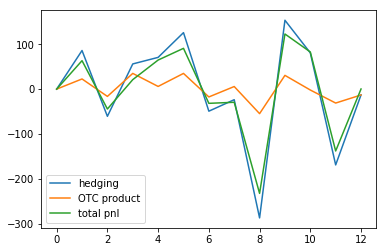

In [366]:

X = C_pnl - O_pnl
plt.plot(C_pnl,label = 'hedging')
plt.plot(O_pnl,label = 'OTC product')
plt.plot(X,label = 'total pnl')
plt.legend()

In [318]:
X = np.array([(2,5),(1,3)])
np.linalg.inv(X).dot(np.array([1,2]))

array([-7.,  3.])

In [313]:
(x,y) = np.ones((2,1))
np.ones((2,1))

array([[1.],
       [1.]])

In [361]:
save_result = list()
save_result.append((X,C_pnl,O_pnl,C_pnl_cost))